<a href="https://colab.research.google.com/github/Galagalagalaga/WildfireResearch23/blob/main/Wildfire22-23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports all libraries and dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Defines file pattern for all data to be trained.

In [ ]:
file_pattern = '/content/drive/MyDrive/Arthur Qin/Data/2022-2023 Data/next_day_wildfire_spread_train*'

Creates lists defining names of all the input and output features.

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

Creates a dictionary with statistics for all of the data, including minimum, maximum, mean, and standard deviation.

In [ ]:
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
  
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

Miscellaneous functions to crop input and output images if desired from the ML model, probably will not use these.


In [ ]:
def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img

Function to extract a base key from an input key that makes sure that all variables in the same base key are normalized in the same way.

In [ ]:
def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.
​
  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.
​
  Args:
    key: Input key.
​
  Returns:
    The corresponding base key.
​
  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))



Functions to clip and normalize inputs of the specified key.

In [ ]:
def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)


Function that creates a dictionary of features (inputs) given a key and sample size. In this case, that is 64x64.

In [ ]:
def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))



Reads data after it has been normalized or modified to a desirable state.

In [ ]:
def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img

Implements all past functions in order to retrieve the dataset into a tensorflow dataset object from a specified file path.

In [ ]:

def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset


Defines the dataset variable.

In [ ]:
side_length = 64 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
num_obs = 100 #batch size

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)




In [ ]:
file_pattern_test = '/content/drive/MyDrive/Arthur Qin/Data/2022-2023 Data/next_day_wildfire_spread_test*'
dataset_test = get_dataset(
    file_pattern_test,
    data_size=64,
    sample_size=side_length,
    batch_size = 100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize = True,
    clip_and_rescale=False,
    random_crop=False,
    center_crop=False
)

In [ ]:
file_pattern_evaluate = '/content/drive/MyDrive/Arthur Qin/Data/2022-2023 Data/next_day_wildfire_spread_eval*'
dataset_evaluate = get_dataset(
    file_pattern_evaluate,
    data_size=64,
    sample_size=side_length,
    batch_size = 100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize = True,
    clip_and_rescale=False,
    random_crop=False,
    center_crop=False
)

Simply defining inputs and labels variables from each iteration of the dataset object.

In [ ]:
inputs, labels = next(iter(dataset))

Defining Titles list for data visualization.

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Preparing variables for data visualization.

In [ ]:
# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

Data visualization proper.

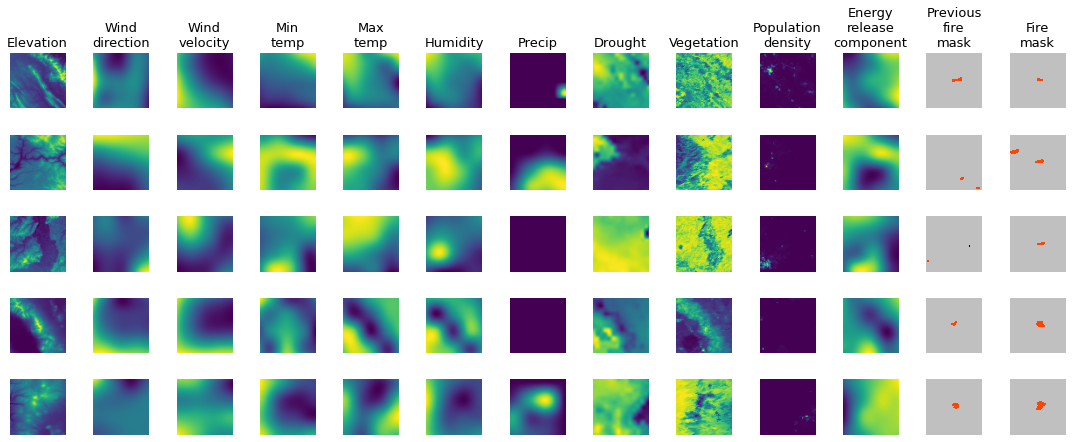

In [ ]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

CNN AUTOENCODER MODEL!!!!!

In [ ]:
#Eventually would like a function that takes in an input array of dimensions nxn, 
#outputs an array that gives avg of each cell's neighbors:
def avg_neighbors(array_in):
    #Check input
    if array_in.shape[0] != array_in.shape[1]:
        raise Exception('Only square arrays make sense here, since you\'re analyzing square arrays.')
    #Maybe should also do type-checking, but leave it for now.
    
    #Prepare the output array:
    n = array_in.shape[0] 
    array_out = np.zeros((n,n))
    
    #Guess who doesn't know how to do signal processing in Python...
    
    for i in range(n):
        for j in range(n):
            if i == 0:
                #Upper edge
                if j == 0:
                    #Upper left corner
                    sum_neighbors = array_in[i+1, j] + array_in[i, j+1] + array_in[i+1, j+1]
                    avg = sum_neighbors/3
                    
                elif j == (n-1):
                    #Upper right corner
                    sum_neighbors = array_in[i, j-1] + array_in[i+1, j] + array_in[i+1, j-1]
                    avg = sum_neighbors/3
                    
                else:
                    #Upper edge except corners
                    sum_neighbors = array_in[i, j-1] + array_in[i+1, j] + array_in[i, j+1] + array_in[i+1, j-1] + array_in[i+1, j+1]
                    avg = sum_neighbors/5
                   
            elif i == (n-1):
                #Lower edge
                if j == 0:
                    #Lower left corner
                    sum_neighbors = array_in[i-1, j] + array_in[i, j+1] + array_in[i-1, j+1]
                    avg = sum_neighbors/3
                    
                elif j == (n-1):
                    #Lower right corner
                    sum_neighbors = array_in[i, j-1] + array_in[i-1, j] + array_in[i-1, j-1]
                    avg = sum_neighbors/3
                    
                else:
                    #Lower edge except corners
                    sum_neighbors = array_in[i, j-1] + array_in[i, j+1] + array_in[i-1, j] + array_in[i-1, j-1] + array_in[i-1, j+1]
                    avg = sum_neighbors/5
                    
            else:
                if j == 0:
                    #Left edge except corners
                    sum_neighbors = array_in[i-1, j] + array_in[i+1, j] + array_in[i, j+1] + array_in[i-1, j+1] + array_in[i+1, j+1]
                    avg = sum_neighbors/5
                    
                elif j == (n-1):
                    #Right edge except corners
                    sum_neighbors = array_in[i-1, j] + array_in[i+1, j] + array_in[i, j-1] + array_in[i-1, j-1] + array_in[i+1, j-1]
                    avg = sum_neighbors/5
                    
                else:
                    #Not on any edge or corner
                    sum_neighbors = array_in[i, j+1] + array_in[i, j-1] + array_in[i-1, j] + array_in[i+1, j] + \
                                    array_in[i-1, j-1] + array_in[i-1, j+1] + array_in[i+1, j-1] + array_in[i+1, j+1]
                    avg = sum_neighbors/8
                    
                    
            array_out[i,j] = avg
            #/for loop body
        
    return array_out
                    

In [ ]:
prev_fire_masks = inputs[:, :, :, 11] #observation number, pixel row, pixel col

found_it_flag = 0 #will set to 1 once we've found our "interesting" fire mask
img_num = 0
while found_it_flag == 0:
    fire_mask = np.array(prev_fire_masks[img_num, :, :])
    if (np.all( (fire_mask == 0)) ): #if boring picture where there's no fire, toss it
        img_num = img_num + 1
    elif (np.all( np.invert(fire_mask == -1) )): #if NO data is missing data, cond. is TRUE --> you want this one
        test_img = fire_mask
        found_it_flag = 1
    else:
        img_num = img_num + 1

np.set_printoptions(threshold=np.inf) #this just stops Jupyter from truncating the output

In [ ]:
#Try to eliminate all observations where there are uncertain squares in the previous fire mask.
prev_masks_array = np.array(inputs[:, :, :, 11])
#print(prev_masks_array.shape) #100x32x32—good!

#Build the array of certain data AND SAVE THE INDICES
first_find_flag = 1
count = 0
indices = []

for img_num in range(num_obs): 
    fire_mask = np.array(prev_fire_masks[img_num, :, :])
    if (np.all( np.invert(fire_mask == -1) )): #If no missing data, condition is TRUE.
        count += 1
        indices.append(img_num)
        if first_find_flag == 1: #If you need to start the array
            certain_prev_fire_masks = fire_mask
            first_find_flag = 0  #Remember to turn the flag off!
        else:
            certain_prev_fire_masks = np.dstack((certain_prev_fire_masks, fire_mask)) #d
            

#Test: You want the printouts from the following three lines to be consistent
print(certain_prev_fire_masks.shape)
print(count) 
print(len(indices))

(64, 64, 71)
71
71


In [ ]:
#Now that I've found the observations with "pristine" previous fire masks, I'd like to get those observations' features matrices
full_input_array = np.array(inputs) #100x32x32x12

for i, index in enumerate(indices):
    if i == 0:
        certain_input_array = full_input_array[index,:,:,:]
        print(certain_input_array.shape) #32x32x12
    elif i == 1:
        certain_input_array = np.concatenate((certain_input_array[..., np.newaxis], full_input_array[index,:,:,:, np.newaxis]), axis=3)
    else:
        certain_input_array = np.concatenate((certain_input_array, full_input_array[index,:,:,:, np.newaxis]), axis=3)
        
print(certain_input_array.shape)
#SUCCESS! :) :) :) 
#certain_input_array now holds only the 77 observations with certain previous fire masks

(64, 64, 12)
(64, 64, 12, 71)


In [ ]:
#Also want the labels at only these indices and the average neighbor value matrices
full_labels = np.array(labels)
#print(labels.shape) 100x32x32x1, as expected

for i, index in enumerate(indices):
    if i == 0:
        #labels
        certain_labels = full_labels[index,:,:,:] #32x32x1
        
        #avg neighbor values
        surrounding_fire_scores = avg_neighbors(full_labels[index,:,:,:])
        surrounding_fire_scores = surrounding_fire_scores[..., np.newaxis]
        
    else:
        #labels
        certain_labels = np.concatenate((certain_labels, full_labels[index,:,:,:]), axis=2)
        
        #avg neighbor values
        avg_mat = avg_neighbors(full_labels[index,:,:,:])
        surrounding_fire_scores = np.concatenate((surrounding_fire_scores, avg_mat[...,np.newaxis]), axis=2)

#Printouts from following lines should agree...
print(certain_labels.shape) #32x32x77 
print(surrounding_fire_scores.shape) #32x32x77 
#... and they do! :)

(64, 64, 71)
(64, 64, 71)


In [ ]:
#Function to identify certain observations in the previous fire mask and return:
#1) a list of their indices in the batch (need this to grab the right ones from the labels) and 
#2) the actual array of certain observations

def elim_uncertain(prev_fire_mask_batch):
    
    prev_masks_array = np.array(prev_fire_mask_batch)
    num_imgs, rows, cols = prev_masks_array.shape
    
    #Build the array of certain data AND SAVE THE INDICES
    first_find_flag = 1
    count = 0
    indices = []

    for img_num in range(num_imgs): 
        fire_mask = prev_fire_mask_batch[img_num, :, :] #grab the "working fire mask" off the pile
        
        if (np.all( np.invert(fire_mask == -1) )): #If no missing data, condition is TRUE.
            count += 1
            indices.append(img_num)
            if first_find_flag == 1: #If you need to start the array
                certain_prev_fire_masks_batch = fire_mask
                first_find_flag = 0  #Remember to turn the flag off!
            else:
                certain_prev_fire_masks_batch = np.dstack((certain_prev_fire_masks_batch, fire_mask)) 
    
    return certain_prev_fire_masks_batch, indices

In [ ]:
#Function to extract only the labels (i.e. current fire masks) from the certain observations
def extract_certain_labels(certain_indices, og_labels):
    
    for i, index in enumerate(certain_indices):
        if i == 0:
            extracted_labels = og_labels[index,:,:,:] #the og_labels dimensions are batch_size by sidelength by sidelength by 1
        else:
            #labels
            extracted_labels = np.concatenate((extracted_labels, og_labels[index,:,:,:]), axis=2)

    return extracted_labels

In [ ]:
#Create multi-D array of neighbor fire values
def avg_neighbor_batch(batch_in):
    rows, cols, batch_size = batch_in.shape #ordering of dimensions here meant to be compatible with elim_uncertain and extract_certain_labels
    batch_out = np.zeros((rows, cols, batch_size))
    for i in range(batch_size):
        working_arr = batch_in[:,:,i]
        avgd_arr = avg_neighbors(working_arr)
        batch_out[:,:,i] =  avgd_arr
    #/for loop
    
    return batch_out

In [ ]:
import numpy as np
full_prev_fire_masks = np.array(inputs[:,:,:,11]) #just grabs the previous fire masks from the full observation multi-D array
full_curr_fire_masks = np.array(labels) #100x32x32x1

certain_prev_masks, certain_indices = elim_uncertain(full_prev_fire_masks) #32x32x86 (generally: sidelength^2 x #certain obs.)
certain_labels = extract_certain_labels(certain_indices, full_curr_fire_masks) #32x32x86 (generally: sidelength^2 x #certain obs.)
avg_neighbors_feat = avg_neighbor_batch(certain_prev_masks) #32x32x86 (generally: sidelength^2 x #certain obs.)

flat_prev_masks = []

#Remembering that Python is zero-indexed is going to be VERY IMPORTANT in the below!
for obs in range(certain_prev_masks.shape[2]):
    for row in range(certain_prev_masks.shape[0]):
        for col in range(certain_prev_masks.shape[1]):
            flat_prev_masks.append(certain_prev_masks[row, col, obs])
flat_prev_masks = np.array(flat_prev_masks)

#Vectorize avg neighbors
flat_avg_nbrs = []
for obs in range(avg_neighbors_feat.shape[2]):
    for row in range(avg_neighbors_feat.shape[0]):
        for col in range(avg_neighbors_feat.shape[1]):
            flat_avg_nbrs.append(avg_neighbors_feat[row, col, obs])
flat_avg_nbrs = np.array(flat_avg_nbrs)

X_train = np.vstack((np.transpose(flat_prev_masks), np.transpose(flat_avg_nbrs))) 
X_train = np.transpose(X_train) 

In [ ]:
flat_labels = []
for obs in range(certain_labels.shape[2]):
    for row in range(certain_labels.shape[0]):
        for col in range(certain_labels.shape[1]):
            flat_labels.append(certain_labels[row, col, obs])
flat_labels = np.array(flat_labels)

Y_train = flat_labels
#print(Y_train.shape)



In [ ]:
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets.mnist import load_data
from numpy import reshape
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:


all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []


In [ ]:
input_img = Input(shape=(64, 64, 12))
enc_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(enc_pool1)
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv2)
enc_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(enc_pool2)
enc_output = MaxPooling2D((2, 2), padding='same')(enc_conv3)
print(enc_output.shape)
dec_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(enc_output)
dec_upsample1= UpSampling2D((2, 2))(dec_conv1)
dec_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(dec_upsample1)
dec_upsample2 = UpSampling2D((2, 2))(dec_conv2)
dec_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_upsample3 = UpSampling2D((2,2))(dec_conv3)
dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)

(None, 8, 8, 16)


In [ ]:
autoencoder = Model(input_img, dec_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) 
 
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 12)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        6976      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        4624  

In [ ]:
num_epochs = 8
history = autoencoder.fit(dataset, epochs=8, validation_data=dataset_test, batch_size=100, shuffle=True)

Epoch 1/8
150/150 [==============================] - 40s 197ms/step - loss: 0.0391 - accuracy: 0.9647 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 2/8
150/150 [==============================] - 16s 108ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 3/8
150/150 [==============================] - 15s 100ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 4/8
150/150 [==============================] - 11s 75ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 5/8
150/150 [==============================] - 11s 74ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 6/8
150/150 [==============================] - 11s 73ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9603
Epoch 7/8
150/150 [==============================] - 11s 75ms/step - loss: 0.0342 - accuracy: 0.9658 - val_loss: 0.0397 - val_accuracy: 0.9

In [ ]:
results = autoencoder.evaluate(dataset_evaluate, batch_size=400)

19/19 [==============================] - 5s 213ms/step - loss: 0.0378 - accuracy: 0.9622


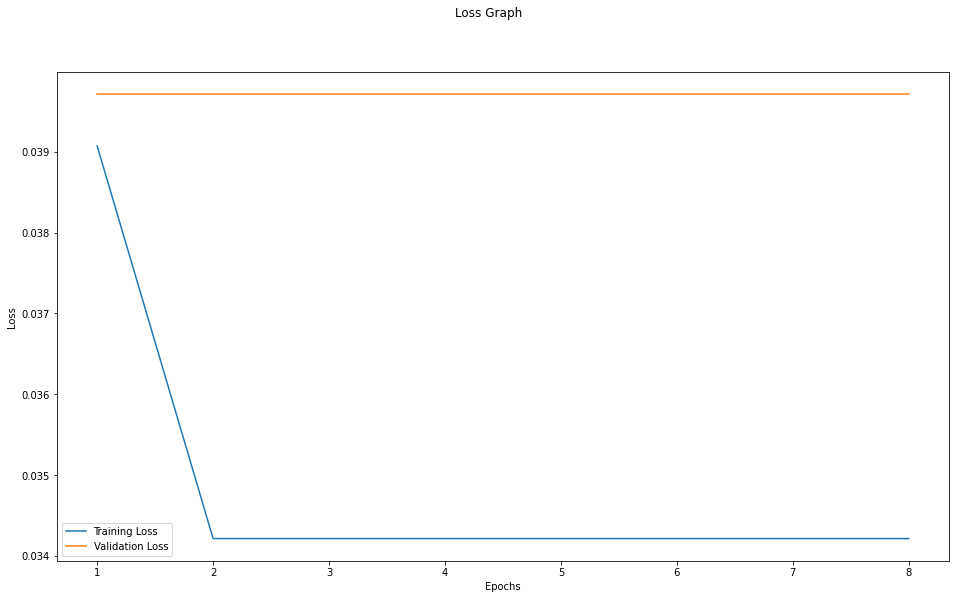

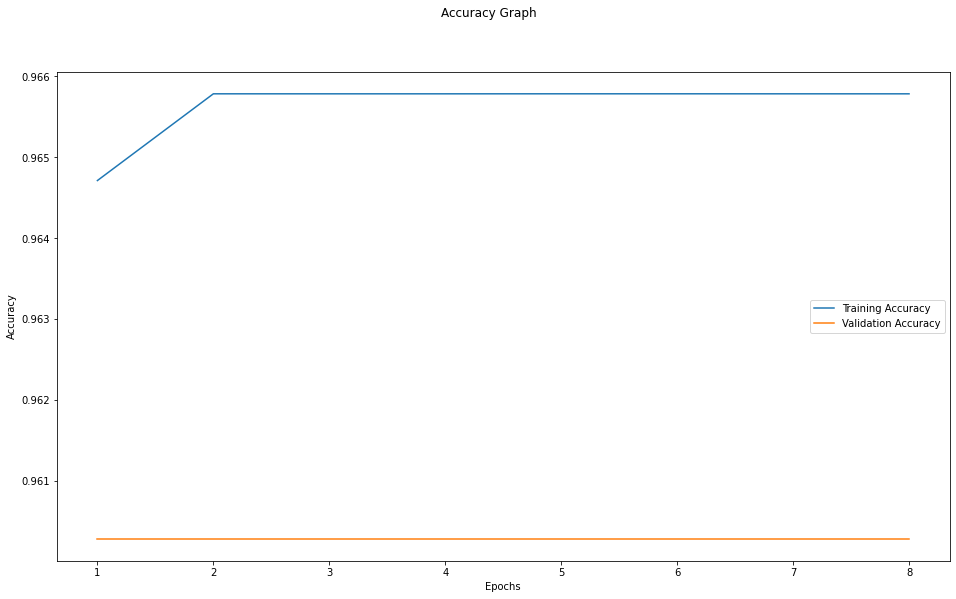

Smooth curve graphs of above graphs


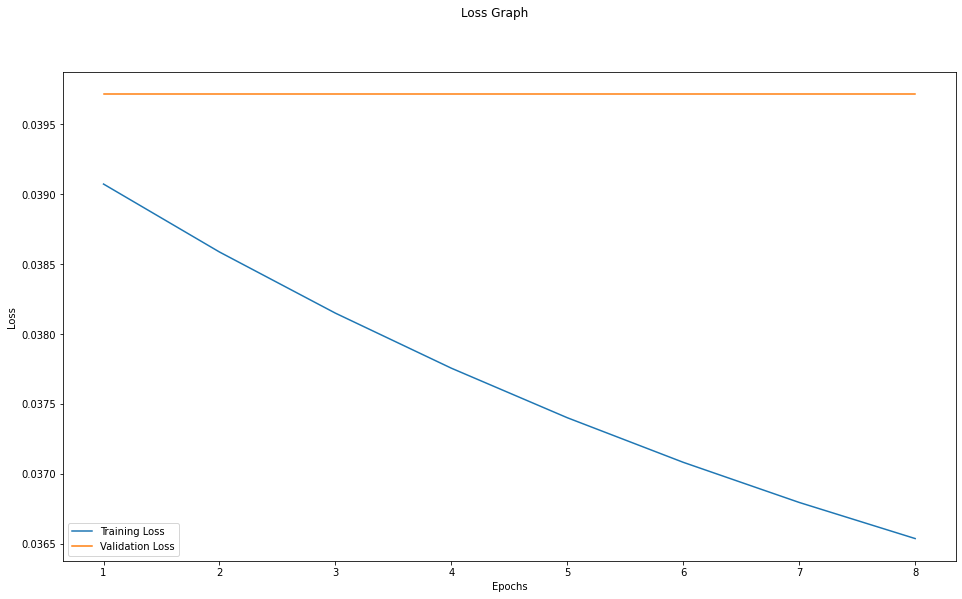

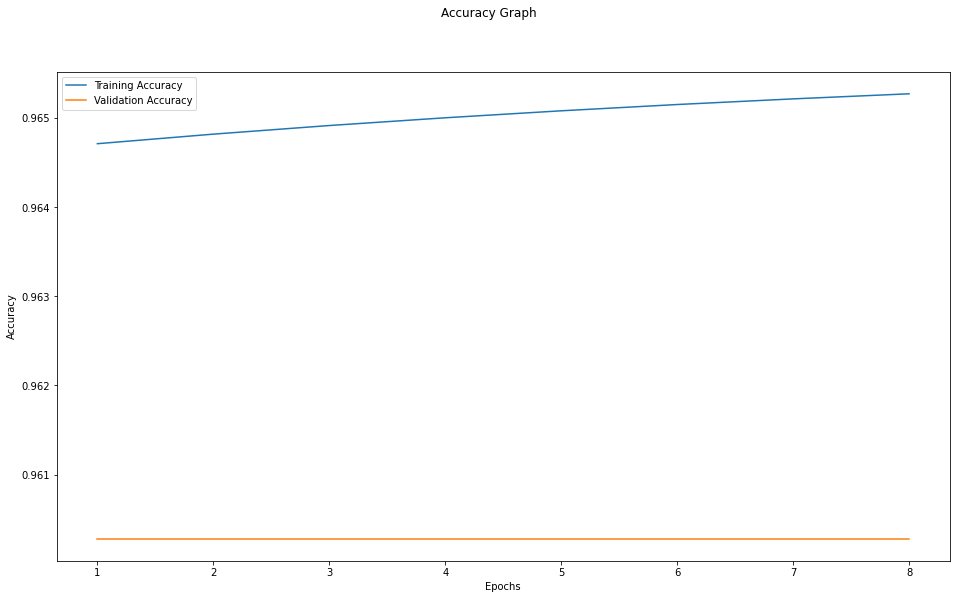

In [ ]:
accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
 
all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)
 
 
def smooth_curve(points, factor=0.9):
   smoothed_points = []
   for point in points:
       if smoothed_points:
           previous = smoothed_points[-1]
           smoothed_points.append(previous * factor + point * (1 - factor))
       else:
           smoothed_points.append(point)
   return smoothed_points
 
def plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories):
   plt.rcParams['figure.figsize'] = (16.0, 9.0)
  
   # Averaging Total fold's accuracy into 1
   average_accuracy_history = [np.mean([x[i] for x in all_accuracy_histories]) for i in range(num_epochs)]
   average_val_accuracy_history = [np.mean([x[i] for x in all_val_accuracy_histories]) for i in range(num_epochs)]
   average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
   average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
  
   #plotting training and validation loss into 1 graph
   plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, label = 'Training Loss')
   plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history, label = 'Validation Loss')
   plt.suptitle('Loss Graph')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.legend()
   plt.show()
  
   #plotting training and validation accuracy into 1 graph
   plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history, label = 'Training Accuracy')
   plt.plot(range(1, len(average_val_accuracy_history) + 1), average_val_accuracy_history, label = 'Validation Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.suptitle('Accuracy Graph')
   plt.legend()
   plt.show()
  
   #plotting smooth curve graphs of loss graph
   print('Smooth curve graphs of above graphs')
   smooth_loss_history = smooth_curve(average_loss_history)
   plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history, label = 'Training Loss')
 
   smooth_val_loss_history = smooth_curve(average_val_loss_history)
   plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history, label = 'Validation Loss')
 
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.suptitle('Loss Graph')
   plt.legend()
   plt.show()
  
   #plotting smooth curve graph of accuracy graph
   smooth_accuracy_history = smooth_curve(average_accuracy_history)
   plt.plot(range(1, len(smooth_accuracy_history) + 1), smooth_accuracy_history, label = 'Training Accuracy')
 
   smooth_val_accuracy_history = smooth_curve(average_val_accuracy_history)
   plt.plot(range(1, len(smooth_val_accuracy_history) + 1), smooth_val_accuracy_history, label = 'Validation Accuracy')
 
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.suptitle('Accuracy Graph')
   plt.legend()
   plt.show()
  
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)
